In [1]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import glob
import numpy as np
import random
import itertools
from collections import Counter

# import nltk
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
# nltk.download('punkt')

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [3]:
bbc_sport_dir = 'bbcsport/'
sport_categories = {
    0: 'athletics',
    1: 'cricket',
    2: 'football',
    3: 'rugby',
    4: 'tennis'
}

sport_text_and_label = []

for idx, label in sport_categories.items():    
    for file_name in glob.glob(bbc_sport_dir + label + '/*.txt'):
        with open(file_name, 'r', encoding='utf8', errors='ignore') as news_file:
            text = news_file.read()
            
#             text_tokenized = word_tokenize(text)
#             text_wo_stopword = [word for word in text_tokenized if not word in STOPWORDS]
            
#             text = ' '.join(text_wo_stopword)
            
        sport_text_and_label.append([text, idx])
        
random.shuffle(sport_text_and_label)

In [4]:
# print counts by category from Counter
def show_counts(labels):
    
    # Count total number of each label
    counter = Counter(l for l in labels)
    counter = sorted(counter.items())
    
    print('Document Counts by Category:')
    
    for label, count in counter:
        cat = sport_categories.get(label)
        print("'{}': {}".format(cat, count))

In [5]:
# Shuffle documents for random sampling
random.shuffle(sport_text_and_label)

# Seperate text and label into two lists
sport_text = [text[0] for text in sport_text_and_label]
sport_label = [label[1] for label in sport_text_and_label]

# Take the first 200 documents as imbalence sample
train_text = sport_text[:600]
train_label = sport_label[:600]

# Remaining text and label for model trainning
sample_text = sport_text[600:]
sample_label = sport_label[600:]

In [6]:
print("Total Numbers of Sport Documents: {}".format(len(sport_text_and_label)))
show_counts(sport_label)

print("\nNumbers of Documents in Training Set: {}".format(len(train_text)))
show_counts(train_label)

print("\nNumbers of Documents in Remaining Data: {}".format(len(sample_text)))
show_counts(sample_label)

Total Numbers of Sport Documents: 737
Document Counts by Category:
'athletics': 101
'cricket': 124
'football': 265
'rugby': 147
'tennis': 100

Numbers of Documents in Imbalence Sample: 600
Document Counts by Category:
'athletics': 84
'cricket': 97
'football': 220
'rugby': 117
'tennis': 82

Numbers of Documents in Remaining Data: 137
Document Counts by Category:
'athletics': 17
'cricket': 27
'football': 45
'rugby': 30
'tennis': 18


In [8]:
# Create tokenizer for vectorizing documents, using the top 3000 most common words only
tokenizer = Tokenizer(num_words=3000, oov_token='<oov>')

# Updates internal vocabulary based on the BBC Sport Documents
tokenizer.fit_on_texts(sport_text)

# Transform each document into sequence
sport_seq = tokenizer.texts_to_sequences(train_text)
sample_seq = tokenizer.texts_to_sequences(sample_text)

# Use padding to ensure each sequence has the same length
sport_pad = pad_sequences(sport_seq, maxlen=300, padding='post', truncating='post')
sample_pad = pad_sequences(sample_seq, maxlen=300, padding='post', truncating='post')

sport_labels = np.array(train_label)
sport_labels = sport_labels.reshape(600, 1)

sample_labels = np.array(sample_label)
sample_labels = sample_labels.reshape(137, 1)

In [10]:
# Use RNN model to train on the remaining documents

sport_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(3000, 128),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

sport_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

sport_model.fit(sport_pad, sport_labels, epochs=15)

Epoch 1/15
19/19 [==============================] - 0s 3ms/step - loss: 1.5871 - accuracy: 0.3550
Epoch 2/15
19/19 [==============================] - 0s 3ms/step - loss: 1.5232 - accuracy: 0.3667
Epoch 3/15
19/19 [==============================] - 0s 3ms/step - loss: 1.4518 - accuracy: 0.3667
Epoch 4/15
19/19 [==============================] - 0s 3ms/step - loss: 1.3605 - accuracy: 0.3667
Epoch 5/15
19/19 [==============================] - 0s 3ms/step - loss: 1.2429 - accuracy: 0.4100
Epoch 6/15
19/19 [==============================] - 0s 3ms/step - loss: 1.0856 - accuracy: 0.5633
Epoch 7/15
19/19 [==============================] - 0s 3ms/step - loss: 0.9070 - accuracy: 0.7483
Epoch 8/15
19/19 [==============================] - 0s 3ms/step - loss: 0.7114 - accuracy: 0.8667
Epoch 9/15
19/19 [==============================] - 0s 3ms/step - loss: 0.5290 - accuracy: 0.9350
Epoch 10/15
19/19 [==============================] - 0s 3ms/step - loss: 0.3784 - accuracy: 0.9683
Epoch 11/15
19/19 [

In [11]:
# Extract the embedding layer after trainning
embeddings = sport_model.get_weights()[0]
embeddings[0]

array([-3.01372334e-02,  4.38767597e-02, -4.01930027e-02, -3.01616564e-02,
       -6.22258708e-02,  5.74446954e-02,  5.81190512e-02, -4.12960202e-02,
        5.84351160e-02,  5.64180985e-02,  6.99737284e-05,  5.46285175e-02,
       -7.99167082e-02,  7.16535002e-02,  1.95751786e-02,  4.38547917e-02,
       -4.27971669e-02,  4.06474583e-02,  1.12804901e-02, -2.85063498e-02,
       -2.74395607e-02, -8.13343562e-03, -3.02048251e-02,  1.09143555e-02,
        2.80296504e-02,  6.96741557e-03,  3.01072337e-02, -4.45455834e-02,
       -9.62859467e-02,  9.27900337e-03,  2.77403127e-02, -4.11902331e-02,
       -9.94582311e-04,  3.28898169e-02,  5.90741187e-02,  4.01172694e-03,
       -9.14350301e-02,  2.31148172e-02, -4.16140594e-02,  3.75267640e-02,
       -3.29252481e-02, -1.08950391e-01,  3.72874439e-02,  2.01109927e-02,
        4.36264910e-02,  4.52501588e-02, -1.45687908e-01, -6.88736364e-02,
        8.46143216e-02,  4.02223552e-03, -4.02220786e-02,  1.33862030e-02,
        4.95534241e-02,  

In [12]:
# Get the first 3000 most common word index from the tokenizer
word_to_idx = dict(itertools.islice(tokenizer.word_index.items(), 3000))

In [13]:
# Assign the trained embedding to each word
words_embeddings = {word : embeddings[idx - 1] for word, idx in word_to_idx.items()}

In [14]:
# Create the embedding matrix from the trained word embedding
embedding_matrix = np.zeros((3000, 128))
for word, index in word_to_idx.items():
    embedding_vector = words_embeddings.get(word)
    embedding_matrix[index - 1] = embedding_vector

In [15]:
embedding_matrix

array([[-0.03013723,  0.04387676, -0.040193  , ..., -0.03600681,
         0.08590029,  0.03223067],
       [-0.024921  ,  0.09258873, -0.03712033, ..., -0.06735639,
         0.0821451 ,  0.06785607],
       [-0.03562299,  0.01923736, -0.01145132, ..., -0.03432077,
         0.06249587,  0.06361321],
       ...,
       [ 0.03539127,  0.01214019,  0.02039639, ..., -0.02400829,
        -0.01458883,  0.07844969],
       [-0.13934796,  0.04170195, -0.09892324, ...,  0.09848731,
         0.13370821, -0.14663103],
       [ 0.02685961,  0.07311668, -0.02783104, ...,  0.09831477,
         0.06612629, -0.00431658]])

In [276]:
glove = open('glove/glove.6B.100d.txt', encoding='utf8')

embeddings_dict = dict()

for line in glove:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dict[word] = vector_dimensions

glove.close()

embeddings_dict = dict(itertools.islice(embeddings_dict.items(), 3000))

glove_embedding_matrix = np.zeros((3000, 100))
for word, index in word_to_idx.items():
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        glove_embedding_matrix[index - 1] = embedding_vector

In [16]:
def get_samples(sample_size=200):
    # Shuffle documents for random sampling
    random.shuffle(sport_text_and_label)

    # Seperate text and label into two lists
    sport_text = [text[0] for text in sport_text_and_label]
    sport_label = [label[1] for label in sport_text_and_label]

    # Take the first 200 documents as imbalence sample
    sample_text = sport_text[:sample_size]
    sample_label = sport_label[:sample_size]

#     print("\nNumbers of Documents in Imbalence Sample: {}".format(len(sample_text)))
#     show_counts(sample_label)
    
#     Split the sample data into train, test and validation set
    sample_train_text, sample_test_text, sample_train_label, sample_test_label = train_test_split(
            sample_text, sample_label, test_size=0.2
    )
    train_size = len(sample_train_text)
    test_size = len(sample_test_text)

    # Transform each document into sequence
    sample_train_seq = tokenizer.texts_to_sequences(sample_train_text)
    sample_test_seq = tokenizer.texts_to_sequences(sample_test_text)

    # Use padding to ensure each sequence has the same length
    sample_train_pad = pad_sequences(sample_train_seq, maxlen=300, padding='post', truncating='post')
    sample_test_pad = pad_sequences(sample_test_seq, maxlen=300, padding='post', truncating='post')
    
    sample_train_label = np.array(sample_train_label)
    sample_train_label = sample_train_label.reshape(train_size, 1)
    
    sample_test_label = np.array(sample_test_label)
    sample_test_label = sample_test_label.reshape(test_size, 1)
    
    return sample_train_pad, sample_train_label, sample_test_pad, sample_test_label


In [25]:
'''
After retriving the pre-trained embedding, we take random sample from the sport text,
for each sample, we split it into train, test set (0.8,0.2) and fit into a model
with pre-trained embedding (the embedding layer is freezed, not trainable).

With different training epochs (start from 1 epoch) to train the model,
we take different random sample size and plot out each training and testing accuracy

    eg. at loop with epoch = 3, size = 200, 
        we take sample size of 200 documents and split them into train, test set,
        build the model with pre-trained embedding with epoch = 3 to train on the sample data,
        then plot out the final training accuracy and testing accuracy
'''
def bbcsport_transfer_learning(embedding_matrix, emb_dim):
    # Training epoch
    for epoch in range(2, 12, 2):
        record = []
        for size in range(20, 200, 10):

            # Get sample for trainning and testing
            sample_train_pad, sample_train_label, sample_test_pad, sample_test_label = get_samples(size)

            # Create embedding layer based on the pre=trained embedding
            embedding_layer = tf.keras.layers.Embedding(3000, emb_dim, 
                                          embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), 
                                          input_length=300)
            embedding_layer.trainable = False

            # Create model for testing the sample documents based on the pre-trained embedding
            trained_model = tf.keras.Sequential([
                embedding_layer,
                tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
                tf.keras.layers.Dropout(0.5),
                tf.keras.layers.Dense(64, activation='relu'),
                tf.keras.layers.Dense(5, activation='softmax')
            ])

            trained_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

            history = trained_model.fit(sample_train_pad, sample_train_label, epochs=epoch, verbose=0)
            loss, test_accuracy = trained_model.evaluate(sample_test_pad, sample_test_label, verbose=0)
            # predictions = trained_model.predict_classes(sample_test_pad)
            # tf.math.confusion_matrix(sample_test_label, predictions, num_classes=5)

            # Record trainning accuracy (last epoch) and testing accuracy
            record.append((history.history['accuracy'][-1], test_accuracy))

        fig = plt.figure()
        plt.plot(range(20, 200, 10), [train_acc for train_acc, test_acc in record], label='Train Accuracy')
        plt.plot(range(20, 200, 10), [test_acc for train_acc, test_acc in record], label='Test Accuracy')
        plt.legend()
        plt.title('Epoch Numbers: {}'.format(epoch))
        plt.xlabel('Number of Documents')
        plt.ylabel('Accuracy')
        plt.show()

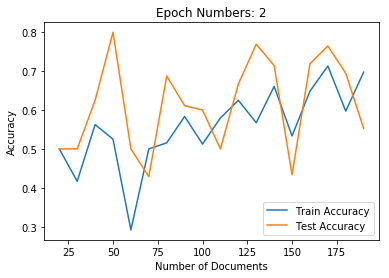

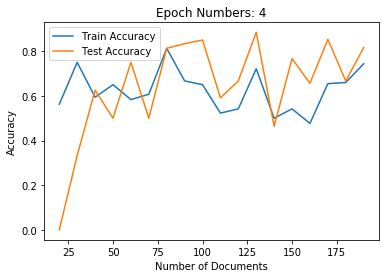

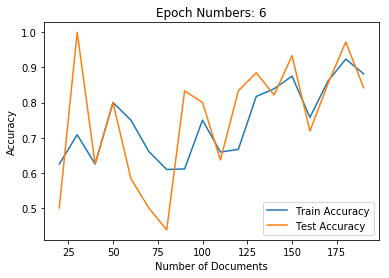

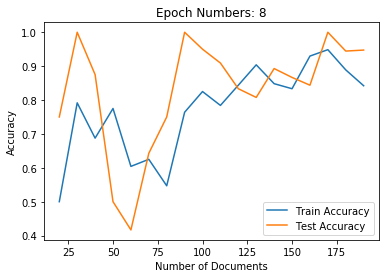

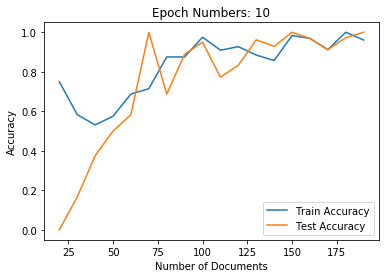

In [26]:
# Using pre-trained embedding from trainning the BBC Sport Documents
bbcsport_transfer_learning(embedding_matrix, 128)

In [122]:
bbc_sport_dir = 'bbcsport/'
sport_categories = {
    0: 'athletics',
    1: 'cricket',
    2: 'football',
    3: 'rugby',
    4: 'tennis'
}

sport_text_and_label = []
sport_text_with_cat = {
    0: [],
    1: [],
    2: [],
    3: [],
    4: []
}

for idx, label in sport_categories.items():    
    for file_name in glob.glob(bbc_sport_dir + label + '/*.txt'):
        with open(file_name, 'r', encoding='utf8', errors='ignore') as news_file:
            text = news_file.read()
            
#             text_tokenized = word_tokenize(text)
#             text_wo_stopword = [word for word in text_tokenized if not word in STOPWORDS]
            
#             text = ' '.join(text_wo_stopword)
        sport_text_with_cat[idx].append(text)
        sport_text_and_label.append([text, idx])
        
# random.shuffle(sport_text_and_label)

In [127]:
# Get imbalance sample, randomly select 1-30 documents from each category
imb_sample_text = []
imb_sample_label = []

for cat, documents in sport_text_with_cat.items():
    sample_size = random.randint(1,30)
    imb_sample_text.extend(random.sample(documents, sample_size))
    imb_sample_label.extend([cat] * sample_size)

In [128]:
imb_sample_text_label = []

for i in range(0, len(imb_sample_text)):
    imb_sample_text_label.append([imb_sample_text[i], imb_sample_label[i]])

In [129]:
random.shuffle(imb_sample_text_label)

In [130]:
show_counts(imb_sample_label)

Document Counts by Category:
'athletics': 14
'cricket': 9
'football': 22
'rugby': 23
'tennis': 3


In [147]:
def process_imb_sample(sample):
    
    # Seperate text and label into two lists
    sport_text = [text[0] for text in sample]
    sport_label = [label[1] for label in sample]
    
#     Split the sample data into train and test set
    sample_train_text, sample_test_text, sample_train_label, sample_test_label = train_test_split(
            sport_text, sport_label, test_size=0.2, shuffle=True
    )
    train_size = len(sample_train_text)
    test_size = len(sample_test_text)

    # Transform each document into sequence
    sample_train_seq = tokenizer.texts_to_sequences(sample_train_text)
    sample_test_seq = tokenizer.texts_to_sequences(sample_test_text)

    # Use padding to ensure each sequence has the same length
    sample_train_pad = pad_sequences(sample_train_seq, maxlen=300, padding='post', truncating='post')
    sample_test_pad = pad_sequences(sample_test_seq, maxlen=300, padding='post', truncating='post')
    
    sample_train_label = np.array(sample_train_label)
    sample_train_label = sample_train_label.reshape(train_size, 1)
    
    sample_test_label = np.array(sample_test_label)
    sample_test_label = sample_test_label.reshape(test_size, 1)
    
    return sample_train_pad, sample_train_label, sample_test_pad, sample_test_label

In [158]:
'''
After retriving the pre-trained embedding, we take imbalance sample from the sport text,
for each sample, we split it into train, test set (0.8,0.2) and fit into a model
with pre-trained embedding (the embedding layer is freezed, not trainable).

Each iteration takes a new imbalance sample, train and test them with the pre-trained embedding
with a LSTM model
'''
def bbcsport_transfer_learning_imb(embedding_matrix, emb_dim):
   
    for _ in range(10):
        imb_sample_text = []
        imb_sample_label = []

        for cat, documents in sport_text_with_cat.items():
            sample_size = random.randint(1,30)
            imb_sample_text.extend(random.sample(documents, sample_size))
            imb_sample_label.extend([cat] * sample_size)

        show_counts(imb_sample_label)

        imb_sample_text_label = []

        for i in range(0, len(imb_sample_text)):
            imb_sample_text_label.append([imb_sample_text[i], imb_sample_label[i]])

        # Get sample for trainning and testing
        imb_sample_train_pad, imb_sample_train_label, imb_sample_test_pad, imb_sample_test_label = process_imb_sample(imb_sample_text_label)

        size = len(imb_sample_train_pad)

        # Create embedding layer based on the pre=trained embedding
        embedding_layer = tf.keras.layers.Embedding(3000, emb_dim, 
                                      embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), 
                                      input_length=300)
        embedding_layer.trainable = False

        # Create model for testing the sample documents based on the pre-trained embedding
        trained_model = tf.keras.Sequential([
            embedding_layer,
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(5, activation='softmax')
        ])

        trained_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        history = trained_model.fit(imb_sample_train_pad, imb_sample_train_label, epochs=30, verbose=0,
                                    validation_data=(imb_sample_test_pad, imb_sample_test_label))
        plot_graphs(history, 'accuracy')

Document Counts by Category:
'athletics': 9
'cricket': 30
'football': 20
'rugby': 27
'tennis': 21


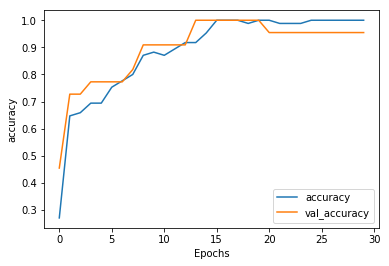

Document Counts by Category:
'athletics': 21
'cricket': 27
'football': 19
'rugby': 21
'tennis': 18


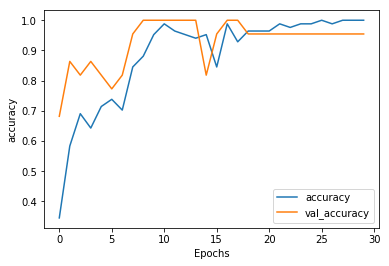

Document Counts by Category:
'athletics': 16
'cricket': 18
'football': 27
'rugby': 16
'tennis': 8


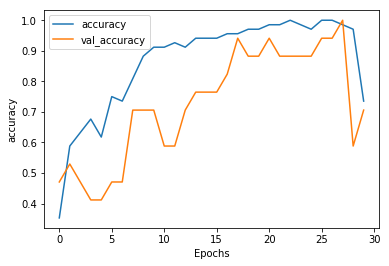

Document Counts by Category:
'athletics': 22
'cricket': 3
'football': 2
'rugby': 3
'tennis': 18


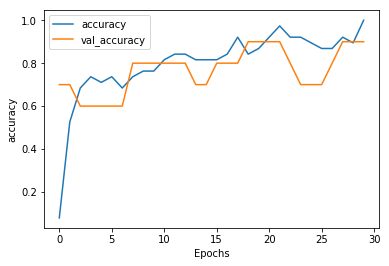

Document Counts by Category:
'athletics': 20
'cricket': 8
'football': 2
'rugby': 7
'tennis': 26


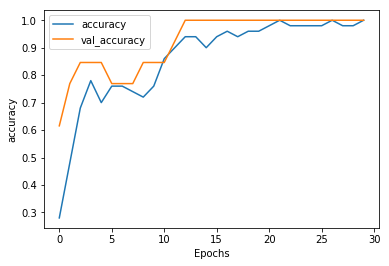

Document Counts by Category:
'athletics': 14
'cricket': 23
'football': 22
'rugby': 3
'tennis': 22


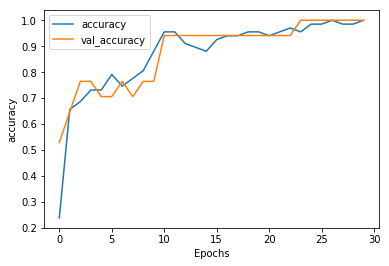

Document Counts by Category:
'athletics': 30
'cricket': 27
'football': 26
'rugby': 8
'tennis': 11


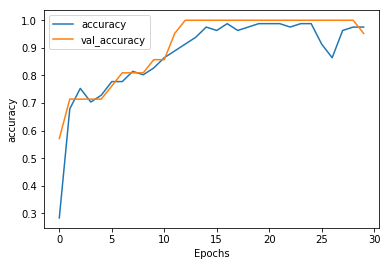

Document Counts by Category:
'athletics': 14
'cricket': 10
'football': 3
'rugby': 25
'tennis': 9


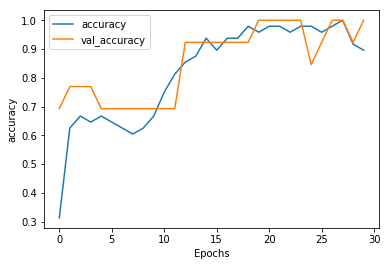

Document Counts by Category:
'athletics': 9
'cricket': 5
'football': 22
'rugby': 25
'tennis': 6


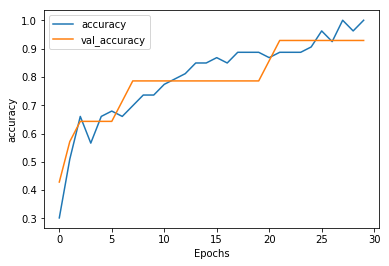

Document Counts by Category:
'athletics': 9
'cricket': 28
'football': 11
'rugby': 5
'tennis': 5


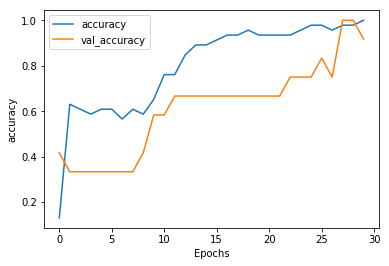

In [159]:
bbcsport_transfer_learning_imb(embedding_matrix, 128)